In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import stats
import analysis_perDRG
import scikit_posthocs as sp

In [2]:
name = 'd7perDRG_'

with open('D7_SNI_area.json') as f:
    results_sni = json.load(f)
with open('D7_Sham_area.json') as f:
    results_sham = json.load(f)

In [3]:
sham_il = analysis_perDRG.GroupData(results_sham, 'IL', number_of_rats=6)
sham_cl = analysis_perDRG.GroupData(results_sham, 'CL', number_of_rats=6)

sni_il = analysis_perDRG.GroupData(results_sni, 'IL', number_of_rats=6)
sni_cl = analysis_perDRG.GroupData(results_sni, 'CL', number_of_rats=6)

C:\Users\Phil Withmore\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Phil Withmore\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
def statistic(group_a_data, group_b_data):
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05):
        # data is not normally distrubuted (<0.05)
        statistic, p_value = stats.mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(group_a_data, group_b_data)
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            print('Welch-test')
        else: 
            equal_variance = True
            print('t-test')
        # perform t-test
        statistic, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=equal_variance, nan_policy='omit')
        print('p-value='+"{:.5f}".format(p_value))

In [5]:
def statistic_all(feature):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)
    
    # Test for normal distribution
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    statistic, p_value_c = stats.shapiro(group_c_data)
    statistic, p_value_d = stats.shapiro(group_d_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05) or (p_value_c < 0.05) or (p_value_d < 0.05):
        # data is not normally distrubuted (<0.05)
        # non-parametric version of ANOVA
        statistic, p_value = stats.kruskal(group_a_data, group_b_data, group_c_data, group_d_data, nan_policy='omit')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
        #perform posthoc mannwhitney-u
        stat = sp.posthoc_mannwhitney([group_a_data, group_b_data, group_c_data, group_d_data])
        
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            # tests the equality of k independent means in the face of heterogeneity of variance
            statistic, p_value = stats.alexandergovern([group_a_data, group_b_data, group_c_data, group_d_data], nan_policy='omit')
            print('Welch’s t-test: p-value='+"{:.5f}".format(p_value))
 
        else: 
            #data is normally distributed and have equal variances
            equal_variance = True
            statistic, p_value = stats.f_oneway(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
            print('one-way ANOVA: p-value='+"{:.5f}".format(p_value))
        stat = sp.posthoc_ttest([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()], equal_var=equal_variance) 
    
    
    stat.columns = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    stat.index = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    return stat.round(4)

In [6]:
def quick_plot(group_a, group_b, feature):
    group_a_data = getattr(group_a, feature)
    group_b_data = getattr(group_b, feature)    
    
    statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(4,6))
    sns.boxplot(data=[group_a_data, group_b_data])
    sns.stripplot(data=[group_a_data, group_b_data], jitter=0.2)
    ax = plt.gca()
    ax.set_xticklabels([group_a.name, group_b.name], fontsize=16)
    plt.ylabel(feature, fontsize=16)
    plt.show()

In [7]:
def plot_all(feature, ylabel):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)      
    #statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(12,8))
    
    labels=['Sham IL', 'Sham CL', 'SNI IL', 'SNI CL']

    c='k'
    alpha=1
    standard_props = {"color":c, "alpha":alpha, "linewidth":5}
    markers= ['D','o']
    line_props = standard_props
    bbox_props = {**standard_props, 'facecolor': 'w', 'edgecolor':c} #dict(edgecolor=c, alpha=alpha, linewidth=5, facecolor='w')
    median_props = standard_props
    cap_props = standard_props
    linewidth = 5
    fontsize = 32
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.tick_params(length=10, width=linewidth)
    if 'tissue area' in ylabel:
        ax.set_ylim([-1, 31])
    elif 'intensities' in ylabel:
        ax.set_ylim([-0.1, 1.01])
    else:
        ax.set_ylim([-1, 101])
    plt.xticks(fontname="Arial", fontsize=fontsize)
    plt.yticks(fontname="Arial", fontsize=fontsize)


    plt.ylabel(ylabel, fontname="Arial", fontsize=34)

    

    sns.boxplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], width=0.5, whiskerprops=line_props, boxprops=bbox_props
                ,capprops=cap_props, medianprops=median_props, fliersize=0)
    sns.stripplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], jitter=0.2, dodge=True, size=8, marker='o', palette='tab20')
    
    ax.set_xticklabels(labels, fontname="Arial", fontsize=34)
    
    plt.savefig('D7 Boxplots/'+name+feature+'.png', bbox_inches = "tight")
    plt.show()

### GFAP rings > 0

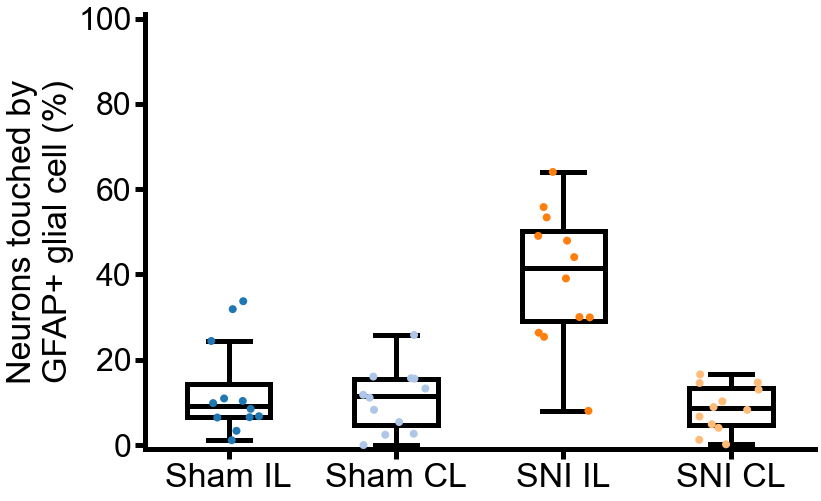

In [8]:
plot_all('ring_ratios_gfap', 'Neurons touched by\nGFAP+ glial cell (%)')

In [9]:
statistic(sni_il.ring_ratios_gfap,sham_il.ring_ratios_gfap)

Mann Whitney U: p-value=0.00111


In [10]:
statistic_all('ring_ratios_gfap')

Mann Whitney U: p-value=0.00019


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9770,0.0011,0.6236
Sham_CL,0.9770,1.0000,0.0003,0.5067
SNI_IL,0.0011,0.0003,1.0000,0.0002
SNI_CL,0.6236,0.5067,0.0002,1.0000


### GS rings > 0

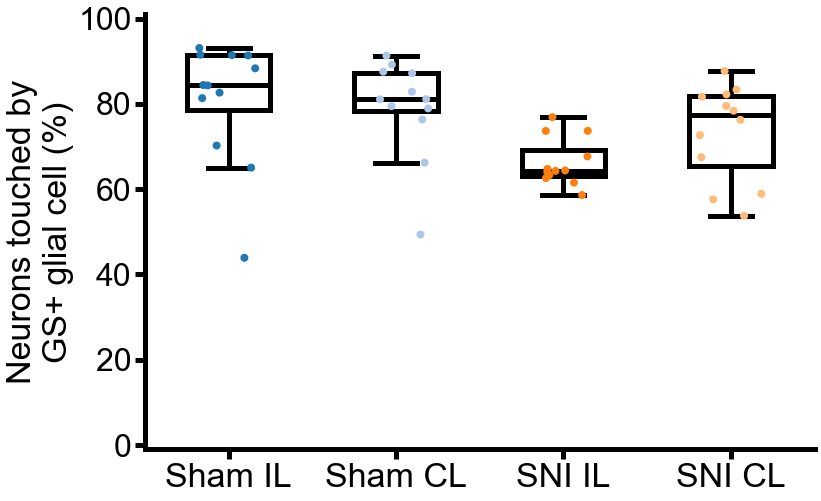

In [11]:
plot_all('ring_ratios_gs', 'Neurons touched by\nGS+ glial cell (%)')

In [12]:
statistic_all('ring_ratios_gs')

Mann Whitney U: p-value=0.00211


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.2855,0.0024,0.0464
Sham_CL,0.2855,1.0000,0.0017,0.1939
SNI_IL,0.0024,0.0017,1.0000,0.0999
SNI_CL,0.0464,0.1939,0.0999,1.0000


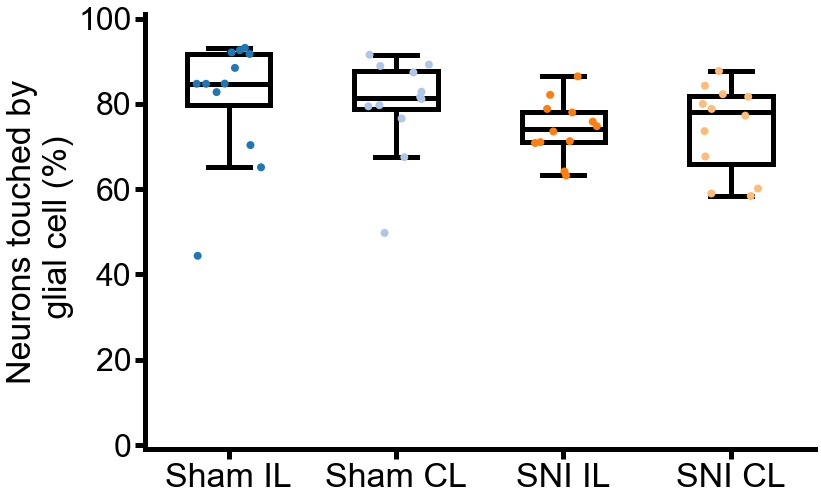

In [13]:
plot_all('ring_ratios_ring', 'Neurons touched by\n glial cell (%)')

In [14]:
statistic_all('ring_ratios_ring')

Mann Whitney U: p-value=0.03925


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.2855,0.0404,0.0304
Sham_CL,0.2855,1.0000,0.0351,0.1939
SNI_IL,0.0404,0.0351,1.0000,0.7075
SNI_CL,0.0304,0.1939,0.7075,1.0000


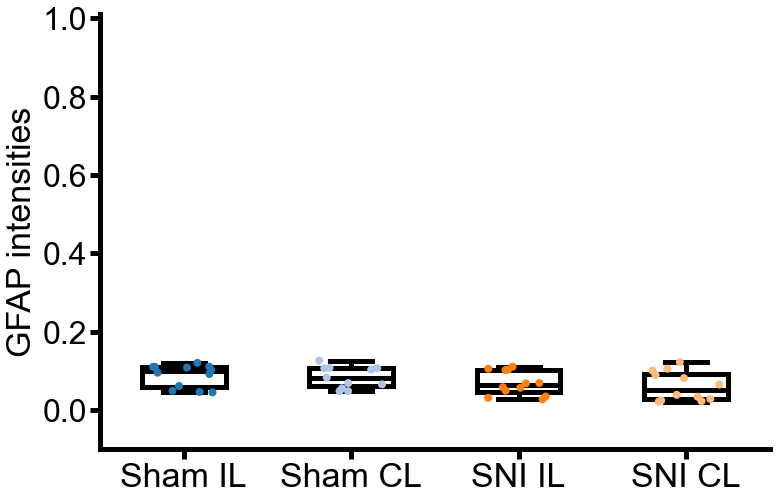

In [15]:
plot_all('gfap_intensities', 'GFAP intensities')

In [16]:
statistic_all('gfap_intensities')

Mann Whitney U: p-value=0.12790


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9770,0.1939,0.0464
Sham_CL,0.9770,1.0000,0.1572,0.0464
SNI_IL,0.1939,0.1572,1.0000,0.4705
SNI_CL,0.0464,0.0464,0.4705,1.0000


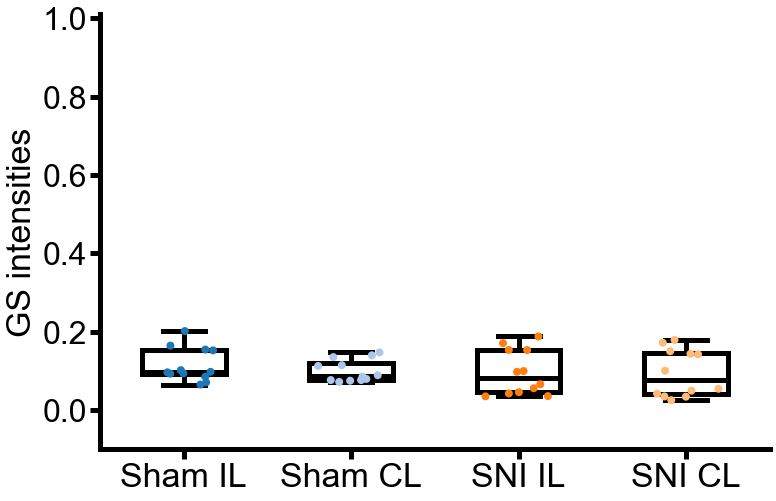

In [17]:
plot_all('gs_intensities', 'GS intensities')

In [18]:
statistic_all('gs_intensities')

Mann Whitney U: p-value=0.61601


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.3708,0.3408,0.2855
Sham_CL,0.3708,1.0000,0.5834,0.7075
SNI_IL,0.3408,0.5834,1.0000,0.6650
SNI_CL,0.2855,0.7075,0.6650,1.0000


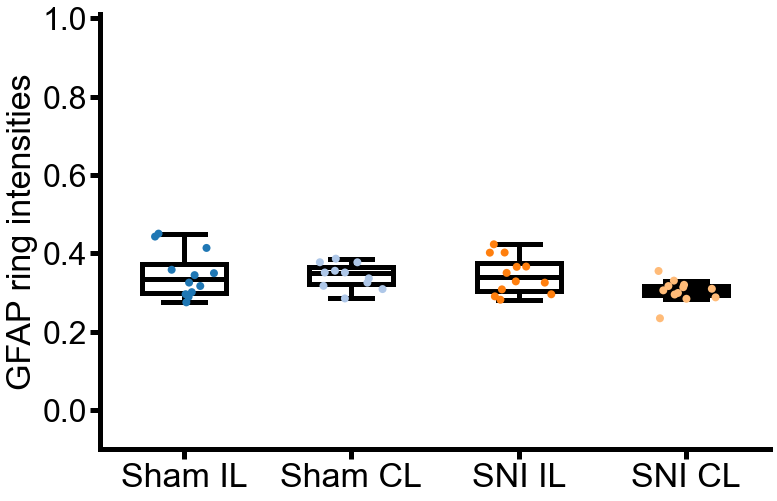

In [19]:
plot_all('gfap_intensities_of_area', 'GFAP ring intensities')

In [20]:
statistic_all('gfap_intensities_of_area')

one-way ANOVA: p-value=0.06802


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8456,0.9303,0.0369
Sham_CL,0.8456,1.0000,0.9061,0.0063
SNI_IL,0.9303,0.9061,1.0000,0.0195
SNI_CL,0.0369,0.0063,0.0195,1.0000


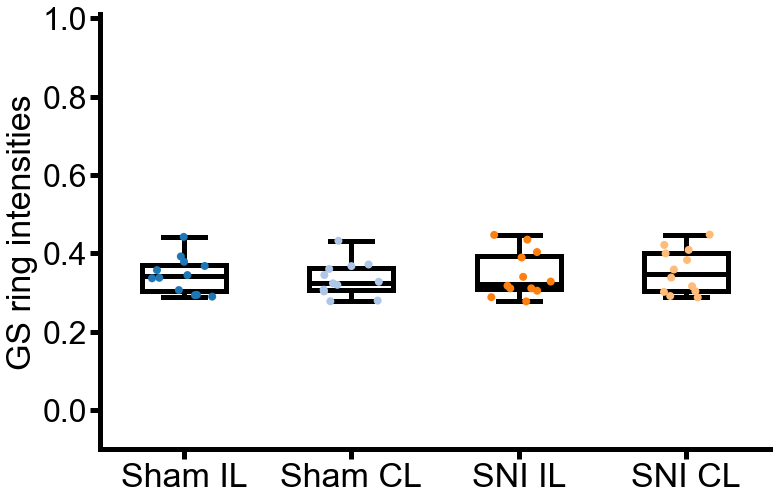

In [21]:
plot_all('gs_intensities_of_area', 'GS ring intensities')

In [22]:
statistic_all('gs_intensities_of_area')

one-way ANOVA: p-value=0.81472


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5745,0.9626,0.6437
Sham_CL,0.5745,1.0000,0.5891,0.3342
SNI_IL,0.9626,0.5891,1.0000,0.7081
SNI_CL,0.6437,0.3342,0.7081,1.0000


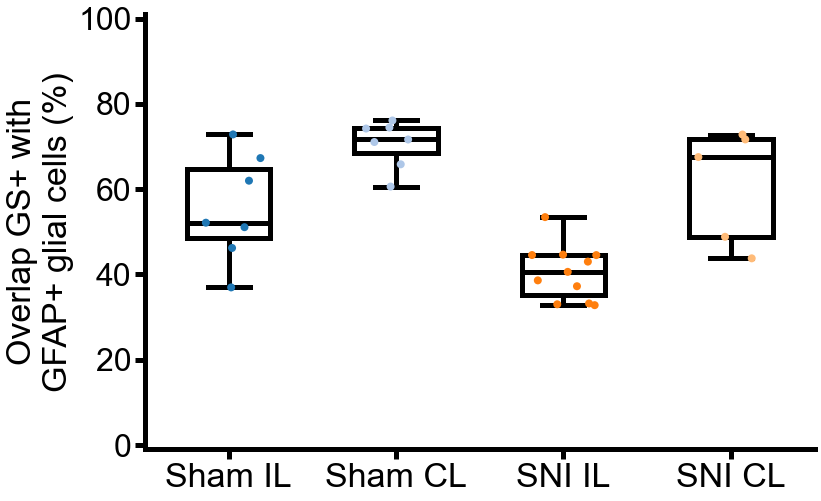

In [23]:
plot_all('gfap_overlaps', 'Overlap GS+ with\nGFAP+ glial cells (%)')

In [24]:
statistic_all('gfap_overlaps')

one-way ANOVA: p-value=0.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.0131,0.0039,0.4917
Sham_CL,0.0131,1.0000,0.0000,0.1174
SNI_IL,0.0039,0.0000,1.0000,0.0009
SNI_CL,0.4917,0.1174,0.0009,1.0000


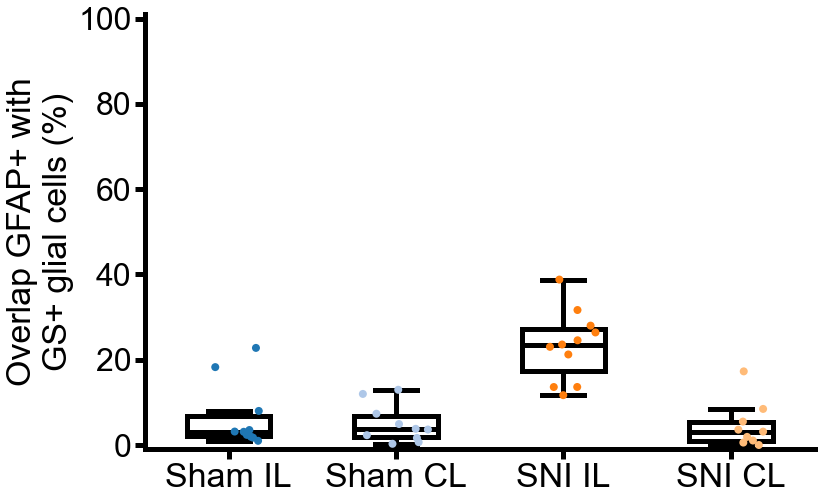

In [25]:
plot_all('gs_overlaps', 'Overlap GFAP+ with\nGS+ glial cells (%)')

In [26]:
statistic_all('gs_overlaps')

one-way ANOVA: p-value=0.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5686,0.0001,0.5309
Sham_CL,0.5686,1.0000,0.0000,0.8823
SNI_IL,0.0001,0.0000,1.0000,0.0000
SNI_CL,0.5309,0.8823,0.0000,1.0000


#### ratio of small neurons vs big neurons
##### maximal small neuron size: diameter=25 µm, area (circular)=491 µm^2 -> 595 pixel
##### minimal neuron size: 246 pixel (based on annotation) --> 202 µm^2

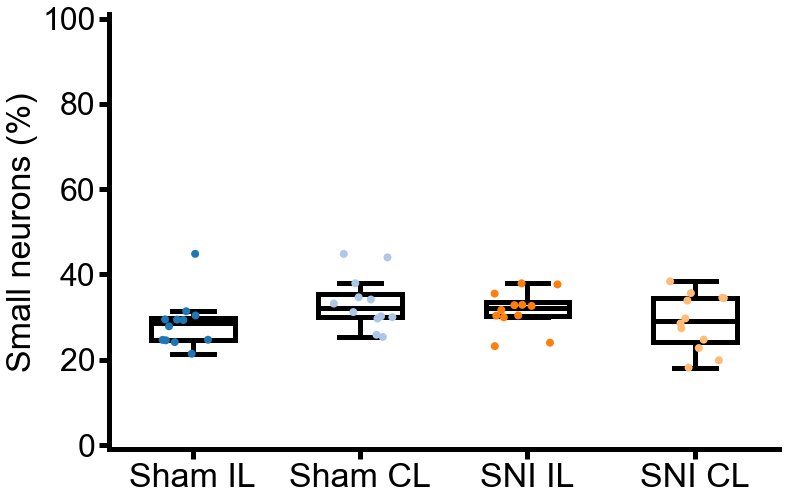

In [27]:
plot_all('small_neurons_percentage', 'Small neurons (%)')

In [28]:
statistic_all('small_neurons_percentage')

Mann Whitney U: p-value=0.09437


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.0194,0.0464,0.6236
Sham_CL,0.0194,1.0000,0.6650,0.1939
SNI_IL,0.0464,0.6650,1.0000,0.4025
SNI_CL,0.6236,0.1939,0.4025,1.0000


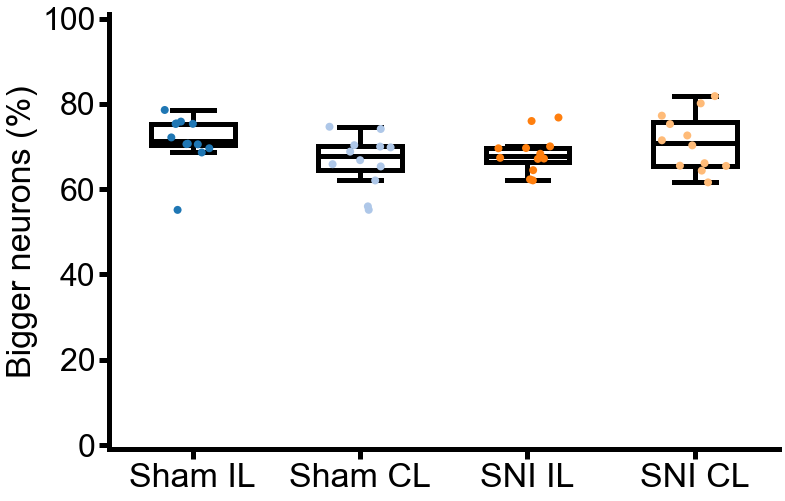

In [29]:
plot_all('bigger_neurons_percentage', 'Bigger neurons (%)')

In [30]:
statistic_all('bigger_neurons_percentage')

Mann Whitney U: p-value=0.09437


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.0194,0.0464,0.6236
Sham_CL,0.0194,1.0000,0.6650,0.1939
SNI_IL,0.0464,0.6650,1.0000,0.4025
SNI_CL,0.6236,0.1939,0.4025,1.0000


In [31]:
stats.kruskal(sham_il.small_neurons_percentage, sham_cl.small_neurons_percentage, sni_il.small_neurons_percentage, sni_cl.small_neurons_percentage)

KruskalResult(statistic=6.383503401360542, pvalue=0.09437181687551205)

In [32]:
stats.f_oneway(sni_il.small_neurons_percentage, sni_cl.small_neurons_percentage, sham_il.small_neurons_percentage, sham_cl.small_neurons_percentage)

F_onewayResult(statistic=1.8138969168391796, pvalue=0.15855200168835623)

In [33]:
sp.posthoc_mannwhitney([sham_il.small_neurons_percentage, sham_cl.small_neurons_percentage, sni_il.small_neurons_percentage, sni_cl.small_neurons_percentage])

,1,2,3,4
1,1.000000,0.019373,0.046387,0.623605
2,0.019373,1.000000,0.665006,0.193931
3,0.046387,0.665006,1.000000,0.402504
4,0.623605,0.193931,0.402504,1.000000


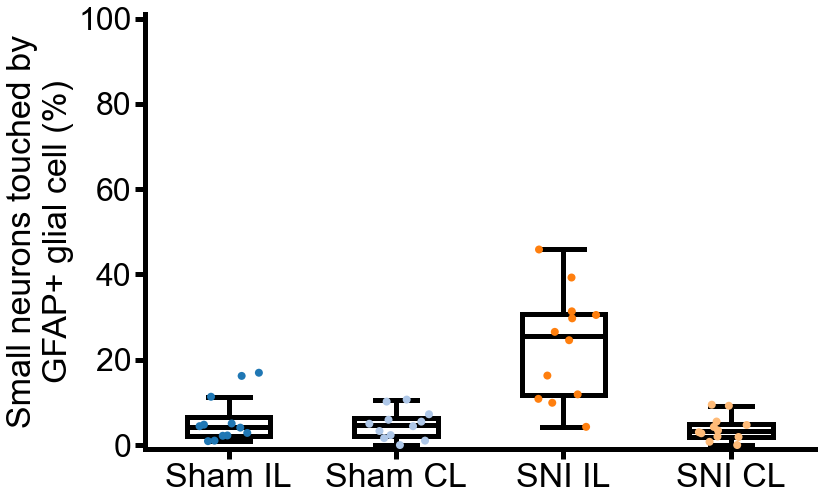

In [34]:
plot_all('small_neurons_gfap_ring', 'Small neurons touched by\nGFAP+ glial cell (%)')

In [35]:
statistic_all('small_neurons_gfap_ring')

Mann Whitney U: p-value=0.00012


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9770,0.0011,0.4357
Sham_CL,0.9770,1.0000,0.0003,0.4883
SNI_IL,0.0011,0.0003,1.0000,0.0001
SNI_CL,0.4357,0.4883,0.0001,1.0000


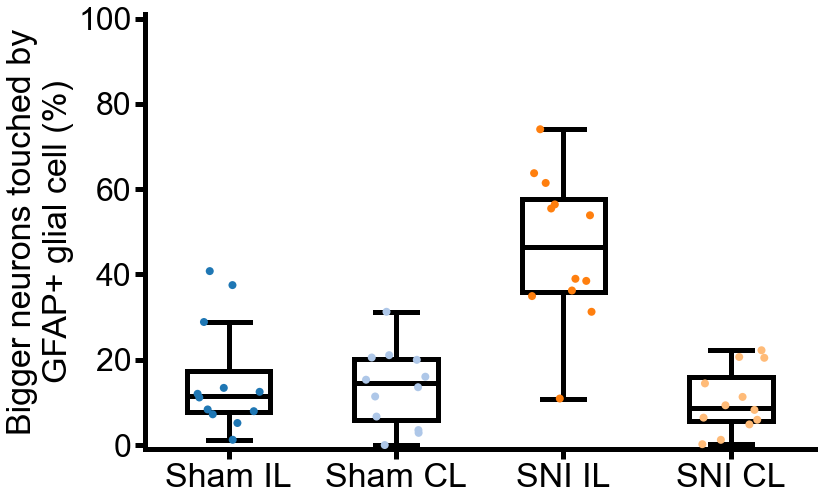

In [36]:
plot_all('bigger_neurons_gfap_ring', 'Bigger neurons touched by\nGFAP+ glial cell (%)')

In [37]:
statistic_all('bigger_neurons_gfap_ring')

Mann Whitney U: p-value=0.00012


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9310,0.0011,0.3708
Sham_CL,0.9310,1.0000,0.0002,0.4705
SNI_IL,0.0011,0.0002,1.0000,0.0001
SNI_CL,0.3708,0.4705,0.0001,1.0000


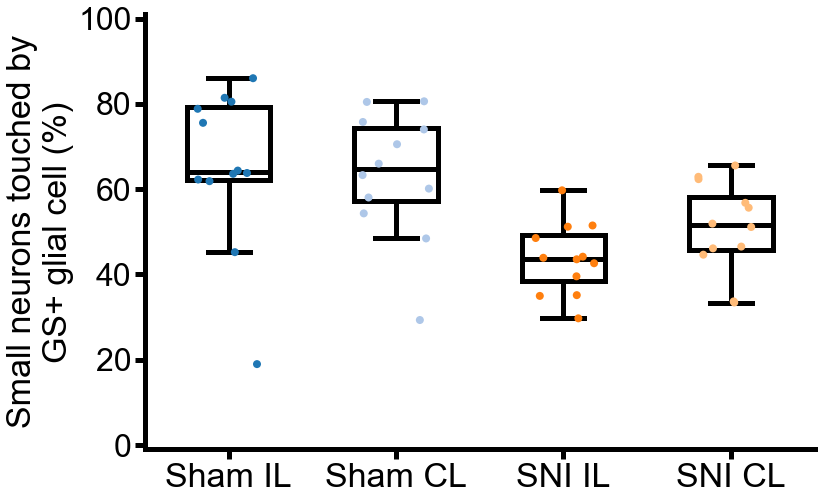

In [38]:
plot_all('small_neurons_gs_ring', 'Small neurons touched by\nGS+ glial cell (%)')

In [39]:
statistic_all('small_neurons_gs_ring')

Mann Whitney U: p-value=0.00050


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5444,0.0014,0.0166
Sham_CL,0.5444,1.0000,0.0020,0.0194
SNI_IL,0.0014,0.0020,1.0000,0.0690
SNI_CL,0.0166,0.0194,0.0690,1.0000


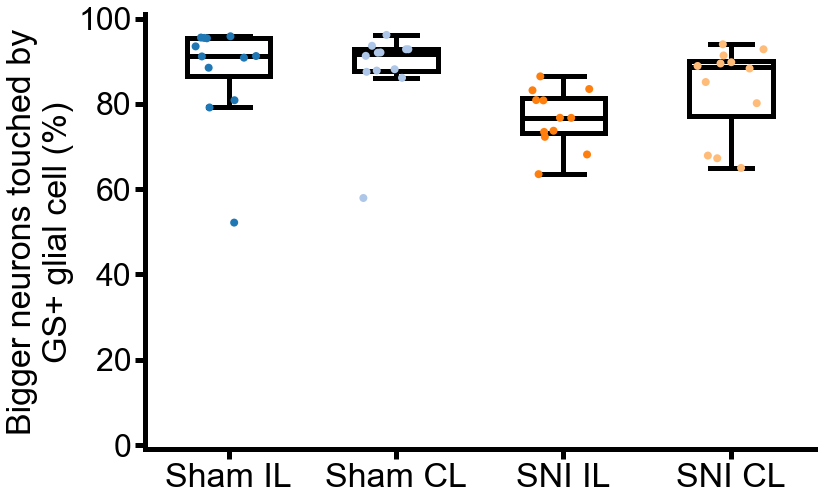

In [40]:
plot_all('bigger_neurons_gs_ring', 'Bigger neurons touched by\nGS+ glial cell (%)')

In [41]:
statistic_all('bigger_neurons_gs_ring')

Mann Whitney U: p-value=0.00267


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8399,0.0035,0.1260
Sham_CL,0.8399,1.0000,0.0007,0.2145
SNI_IL,0.0035,0.0007,1.0000,0.0606
SNI_CL,0.1260,0.2145,0.0606,1.0000


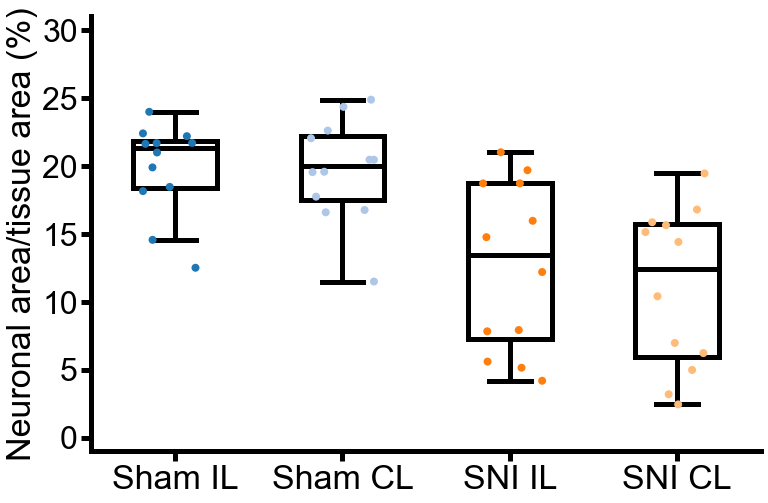

In [42]:
plot_all('neuronal_area_per_tissue', 'Neuronal area/tissue area (%)')

In [43]:
statistic_all('neuronal_area_per_tissue')

one-way ANOVA: p-value=0.00003


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9258,0.0020,0.0002
Sham_CL,0.9258,1.0000,0.0029,0.0003
SNI_IL,0.0020,0.0029,1.0000,0.5062
SNI_CL,0.0002,0.0003,0.5062,1.0000


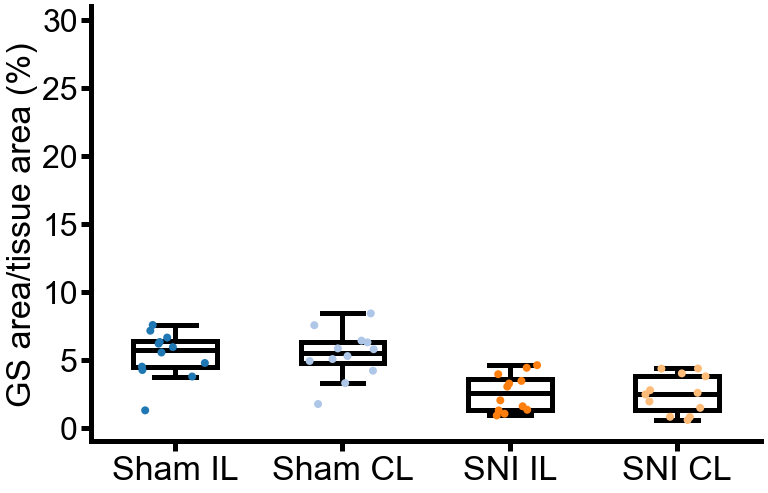

In [44]:
plot_all('gs_area_per_tissue', 'GS area/tissue area (%)')

In [45]:
statistic_all('gs_area_per_tissue')

one-way ANOVA: p-value=0.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9206,0.0003,0.0002
Sham_CL,0.9206,1.0000,0.0003,0.0002
SNI_IL,0.0003,0.0003,1.0000,0.8876
SNI_CL,0.0002,0.0002,0.8876,1.0000


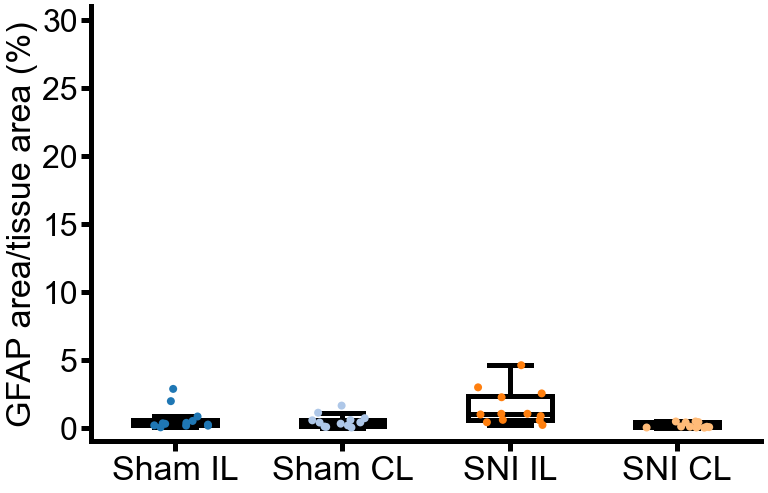

In [46]:
plot_all('gfap_area_per_tissue', 'GFAP area/tissue area (%)')

In [47]:
statistic_all('gfap_area_per_tissue')

Mann Whitney U: p-value=0.00061


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9310,0.0120,0.0464
Sham_CL,0.9310,1.0000,0.0141,0.0690
SNI_IL,0.0120,0.0141,1.0000,0.0002
SNI_CL,0.0464,0.0690,0.0002,1.0000


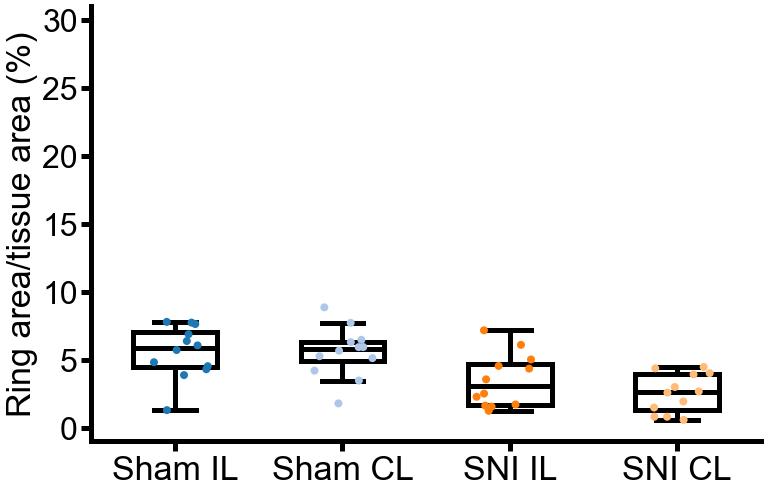

In [48]:
plot_all('ring_area_per_tissue', 'Ring area/tissue area (%)')

In [49]:
statistic_all('ring_area_per_tissue')

one-way ANOVA: p-value=0.00014


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9761,0.0143,0.0002
Sham_CL,0.9761,1.0000,0.0137,0.0002
SNI_IL,0.0143,0.0137,1.0000,0.2044
SNI_CL,0.0002,0.0002,0.2044,1.0000


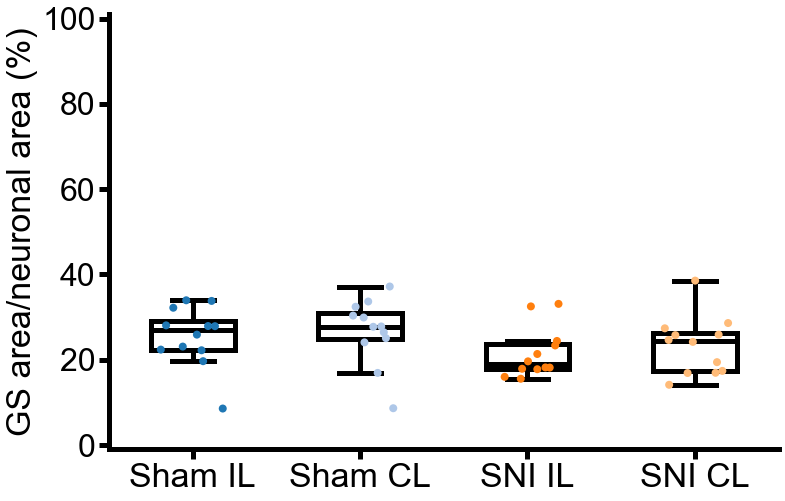

In [50]:
plot_all('gs_area_per_neurons', 'GS area/neuronal area (%)')

In [51]:
statistic_all('gs_area_per_neurons')

Mann Whitney U: p-value=0.12116


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6650,0.0606,0.2602
Sham_CL,0.6650,1.0000,0.0606,0.1410
SNI_IL,0.0606,0.0606,1.0000,0.5444
SNI_CL,0.2602,0.1410,0.5444,1.0000


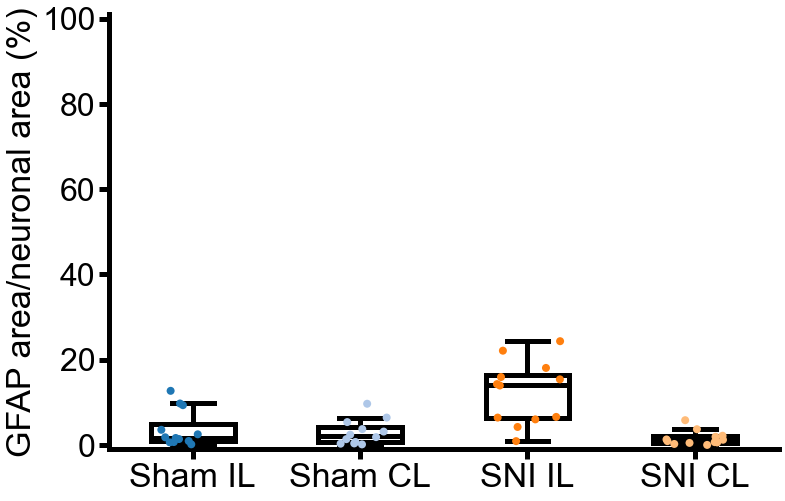

In [52]:
plot_all('gfap_area_per_neurons', 'GFAP area/neuronal area (%)')

In [53]:
statistic_all('gfap_area_per_neurons')

Mann Whitney U: p-value=0.00038


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8399,0.0035,0.1749
Sham_CL,0.8399,1.0000,0.0014,0.2602
SNI_IL,0.0035,0.0014,1.0000,0.0002
SNI_CL,0.1749,0.2602,0.0002,1.0000


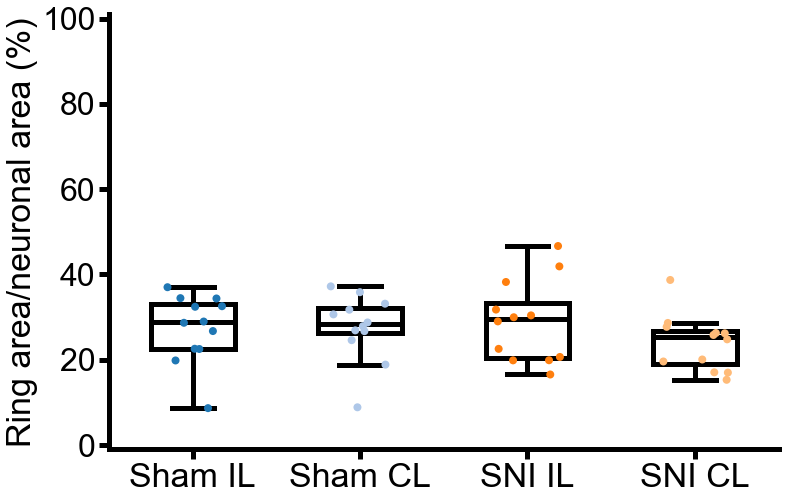

In [54]:
plot_all('ring_area_per_neurons', 'Ring area/neuronal area (%)')

In [55]:
statistic_all('ring_area_per_neurons')

one-way ANOVA: p-value=0.47315


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9521,0.6697,0.2578
Sham_CL,0.9521,1.0000,0.7051,0.2239
SNI_IL,0.6697,0.7051,1.0000,0.1479
SNI_CL,0.2578,0.2239,0.1479,1.0000


In [56]:
sni_cl.ring_area_per_neurons

[15.301321002812466,
 20.0650850287467,
 26.283157794025048,
 16.99033882787919,
 24.790240847434532,
 25.817338024563814,
 28.638201711450723,
 38.717815434678066,
 17.056734751709957,
 27.725150764834478,
 26.206612211893713,
 19.596907717862184]

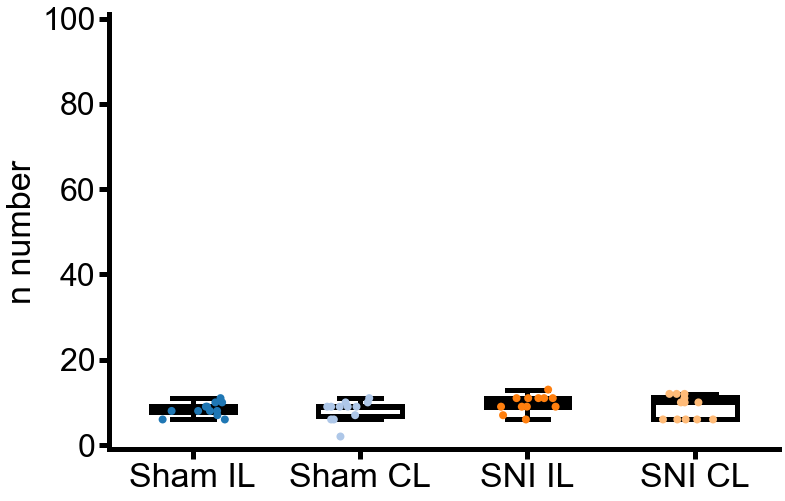

In [57]:
plot_all('n_number', 'n number')

In [58]:
sham_cl.n_number

[9, 10, 2, 9, 10, 7, 9, 9, 6, 11, 9, 6]

In [59]:
sham_cl.ring_ratios_gfap_std

[17.510982336628413,
 20.526578548915907,
 0.0,
 3.095459908468327,
 5.151362844748461,
 2.326231092539416,
 5.284254184794085,
 12.044755326566875,
 4.072095753343129,
 11.96393125504688,
 3.5453172493472755,
 2.0086607463085278]

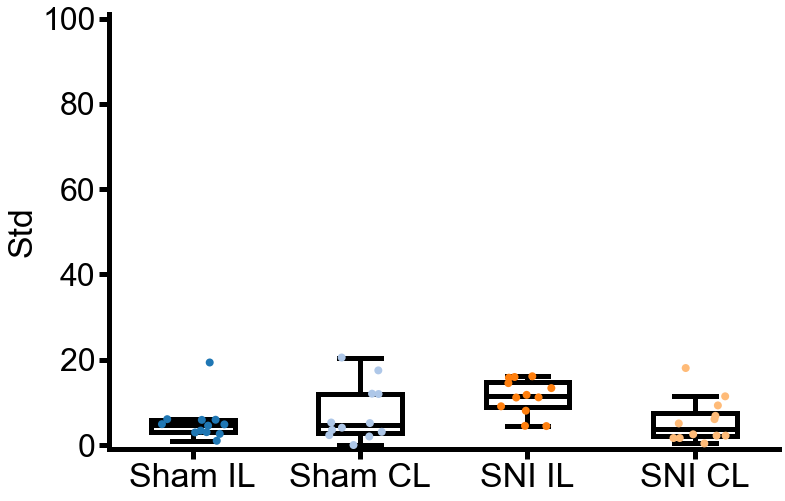

In [60]:
plot_all('ring_ratios_gfap_std', 'Std')